In [1]:
%matplotlib inline
import bezier
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np

# Generate point cache (one point = one voxel)

In [2]:
def list_to_pcache(coords, names):
    """Take a list of coordinates and generates a pcache file.
    Unity has only released a pcache exporter for Houdini, but the
    file format is trivial.
    
    Args:
        coords: an N x M numpy array.
        names: the names of the variables, length M
    
    Returns:
        A string
    """
    assert coords.shape[1] == len(names)
    header = b"pcache\n"
    header += b"comment PCACHE file Exported from Numpy\n"
    header += b"format binary 1.0\n"
    header += b"elements %d\n" % coords.shape[0]
    for n in names:
        header += b"property float " + bytes(n, 'ascii') + b"\n"
    header += b"end_header\n"
    
    return header + np.ascontiguousarray(coords.astype(np.float32)).tostring()

In [6]:
f = h5py.File('cnctm_includeMask_cubed_5_maxLabelsPmask_20000/5tt_length_assignAll_cnctm_mat_single_None.h5', 'r')
lut = np.array(f['lut'])
C = np.array(f['mat'])
nrow = C.sum(1)
ncol = C.sum(0)
good_idx = (nrow + ncol) > 0

C:\Users\zanta\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in add
  


In [7]:
pcache_str = list_to_pcache(lut[good_idx, :][:, [1, 3, 2]], ['position.x', 'position.y', 'position.z'])
with open("point_list.pcache", 'wb') as pcache:
    pcache.write(pcache_str)

# Generate line list

Generate a list that goes from seed voxel to all connected voxels.

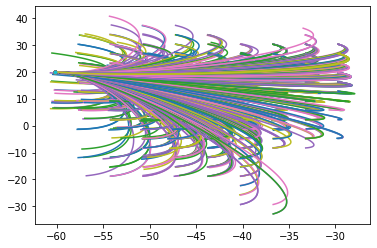

In [8]:
# Now generate lines from one seed location to another.
seed = 1
connections = np.array(f['mat'][seed, :])

# Trace a bezier from seed to destination
targets = np.where(connections > 0)[0]
targets = targets[targets != seed]

ax = plt.gca()
for target in targets[:1000]:
    #target = targets[0]

    c0 = lut[seed, [1, 3, 2]]
    c1 = lut[target, [1, 3, 2]]

    n0 = -c0 / np.sqrt((c0 ** 2).sum())
    n1 = -c1 / np.sqrt((c1 ** 2).sum())

    jump_len = 10

    nodes = np.asfortranarray([[c0[0], c0[0] + jump_len * n0[0], c1[0] + jump_len * n1[0], c1[0]],
                               [c0[1], c0[1] + jump_len * n0[1], c1[1] + jump_len * n1[1], c1[1]]
                               ])

    b = bezier.Curve.from_nodes(nodes)
    b.plot(100, ax=ax)
    
    ax.plot(c0[0], c0[1], '.')

In [9]:
# Now generate lines from one seed location to another.
seed = 1
connections = np.array(f['mat'][seed, :])

# Trace a bezier from seed to destination
targets = np.where(connections > 0)[0]
targets = targets[targets != seed]

all_lines = []
for target in targets[::13]:
    c0 = lut[seed, [1, 3, 2]]
    c1 = lut[target, [1, 3, 2]]

    n0 = -c0 / np.sqrt((c0 ** 2).sum())
    n1 = -c1 / np.sqrt((c1 ** 2).sum())

    jump_len = 10

    nodes = np.asfortranarray([[c0[0], c0[0] + jump_len * n0[0], c1[0] + jump_len * n1[0], c1[0]],
                               [c0[1], c0[1] + jump_len * n0[1], c1[1] + jump_len * n1[1], c1[1]],
                               [c0[2], c0[2] + jump_len * n0[2], c1[2] + jump_len * n1[2], c1[2]]
                               ])

    b = bezier.Curve.from_nodes(nodes)
    coords = b.evaluate_multi(np.linspace(0, 1, 11))
    
    rg = np.linspace(0, 1, 11)
    x = (rg[:-1] + rg[1:]) / 2
    
    all_lines.append(np.concatenate((coords[:, :-1].T, coords[:, 1:].T, x.reshape((-1, 1))), axis = 1))
    
stacked_lines = np.concatenate(all_lines, axis=0)

In [10]:
pcache_str = list_to_pcache(stacked_lines, ['position.x', 'position.y', 'position.z', 
                                              'target.x', 'target.y', 'target.z', 'alpha'])
with open("line_list.pcache", 'wb') as f:
    f.write(pcache_str)

# Manipulate vector fields

In [1]:
import vectorfields
v = vectorfields.VectorField()
